In [32]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

breathDetection_v1.2

This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

New this version: 
- went back to calculating 30s average breath rate

- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

- plotting average of rise and fall breath rate as well (rfmav)

In [33]:
# read in dataset Jill
dset = pd.read_csv('Robin Kirkman - 4-6-16.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))

In [34]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:14000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/20) # add timestamp assuming 20 samples / second
print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp) 

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

   chest  belly  ax  ay  az  gx  gy  gz  time
0   3220   3170 -71  15   6   6  38  -1  0.00
1   3218   3166 -71  13   8   4  34  -3  0.05
2   3217   3165 -71  13   8   2  30  -4  0.10
3   3220   3170 -71  13   8   2  25  -4  0.15
4   3222   3172 -72  15   9   2  21  -4  0.20


In [35]:
f = d

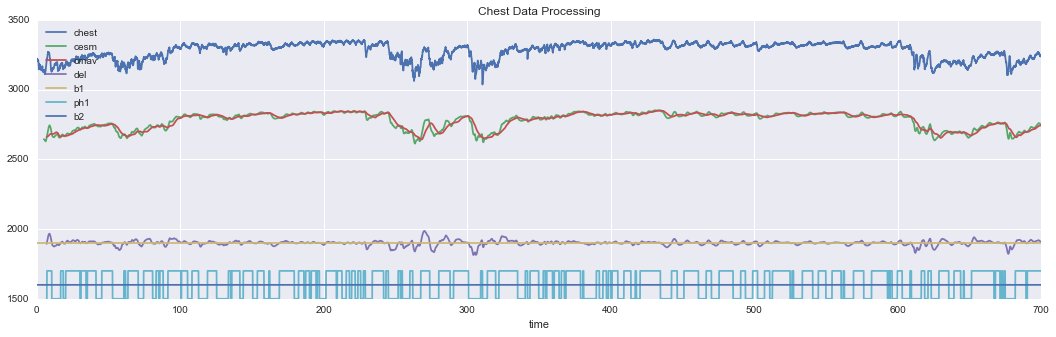

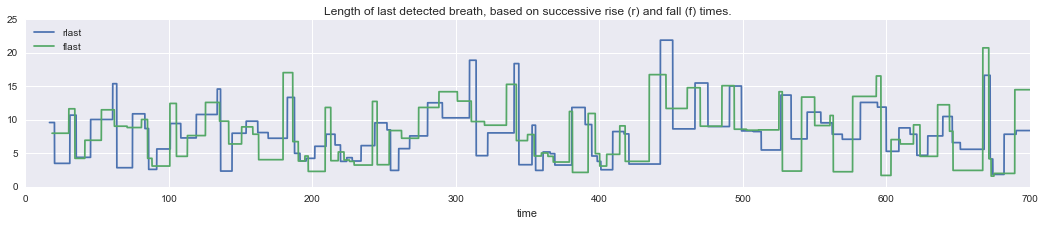

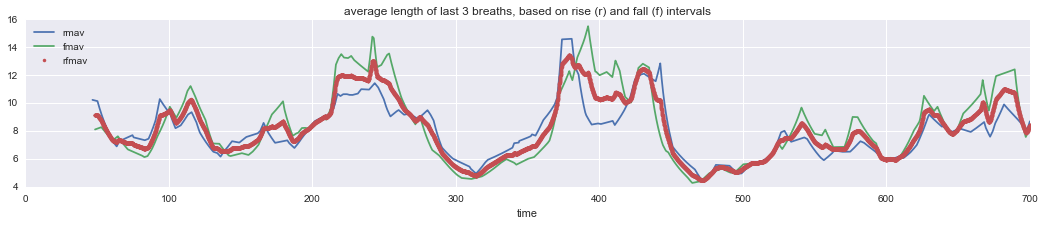

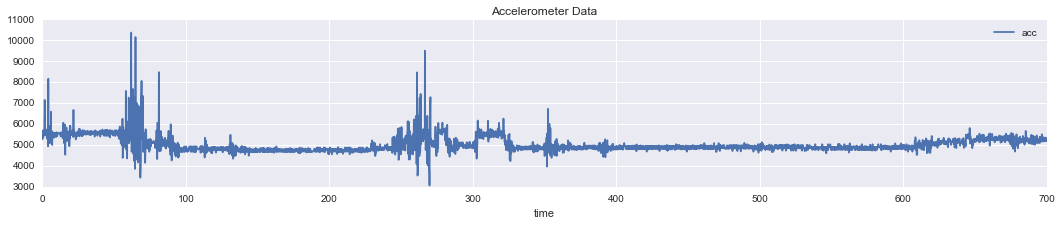

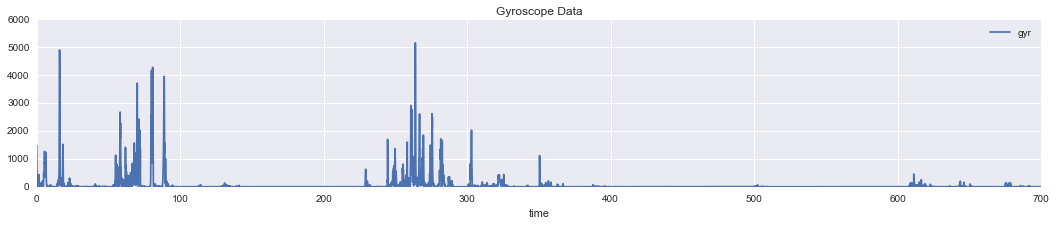

In [36]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 1600
g['b2'] = 1600
g.plot(x = 'time',y = ['chest','cesm','cmav','del','b1','ph1','b2'],figsize = (18,5),title = 'Chest Data Processing')
d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['-','-','.'], x = 'time',y = ['rmav','fmav','rfmav'], figsize = (18,3), title = 'average length of last 3 breaths, based on rise (r) and fall (f) intervals')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [37]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly  ax  ay  az  gx  gy  gz   time  ...   \
0          0   3220   3170 -71  15   6   6  38  -1    0.0  ...    
1000    1000   3265   3243 -69   2  26   1   1  -1   50.0  ...    
2000    2000   3294   3129  19  -9  67   0   0  -1  100.0  ...    
3000    3000   3321   3135  33 -10  59   0   0  -1  150.0  ...    
4000    4000   3311   3151  33 -10  59   0   0  -1  200.0  ...    
5000    5000   3212   3057 -14   2  70   4   7 -13  250.0  ...    
6000    6000   3317   3163  -4  -8  71   0   0  -1  300.0  ...    
7000    7000   3282   3103  16 -11  64  -1   1   0  350.0  ...    
8000    8000   3318   3142  14 -10  67   0   0  -1  400.0  ...    
9000    9000   3315   3159  15 -10  68   0   0  -1  450.0  ...    
10000  10000   3324   3162  15  -9  67   0   0   0  500.0  ...    
11000  11000   3323   3153  20 -12  66   0   0  -1  550.0  ...    
12000  12000   3335   3192  22 -12  65   0   0  -1  600.0  ...    
13000  13000   3168   3062 -15  -1  71   0   0  -1  650.0  ...

In [38]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1,b2
0,0,3220,3170,-71,15,6,6,38,-1,0.00,...,[nan],NaN,NaN,NaN,NaN,NaN,5302,1481,1900,1600
1,1,3218,3166,-71,13,8,4,34,-3,0.05,...,[nan],NaN,NaN,NaN,NaN,NaN,5274,1181,1900,1600
2,2,3217,3165,-71,13,8,2,30,-4,0.10,...,[nan],NaN,NaN,NaN,NaN,NaN,5274,920,1900,1600
3,3,3220,3170,-71,13,8,2,25,-4,0.15,...,[nan],NaN,NaN,NaN,NaN,NaN,5274,645,1900,1600
4,4,3222,3172,-72,15,9,2,21,-4,0.20,...,[nan],NaN,NaN,NaN,NaN,NaN,5490,461,1900,1600
5,5,3222,3178,-72,15,9,0,16,-3,0.25,...,[nan],NaN,NaN,NaN,NaN,NaN,5490,265,1900,1600
6,6,3221,3179,-72,15,9,-1,15,-3,0.30,...,[nan],NaN,NaN,NaN,NaN,NaN,5490,235,1900,1600
7,7,3216,3179,-72,15,9,-1,12,-4,0.35,...,[nan],NaN,NaN,NaN,NaN,NaN,5490,161,1900,1600
8,8,3218,3183,-74,13,7,-2,11,-4,0.40,...,[nan],NaN,NaN,NaN,NaN,NaN,5694,141,1900,1600
9,9,3211,3179,-74,13,7,-6,8,-3,0.45,...,[nan],NaN,NaN,NaN,NaN,NaN,5694,109,1900,1600
